In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.formula.api as smf
from matplotlib.ticker import MultipleLocator

from core.functions import heatmap_corr
from core.functions import logistic_reg

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/raw/motor_vehicle_insurance_data.csv', sep=';', parse_dates=['Date_start_contract', 'Date_last_renewal',
        'Date_next_renewal','Date_birth', 'Date_driving_licence', 'Date_lapse'], dayfirst=True)
display(df.head())
display(df.shape)

C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\3081844874.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/motor_vehicle_insurance_data.csv', sep=';', parse_dates=['Date_start_contract', 'Date_last_renewal',


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,0,4,1,2,1,0,NaT,0,222.52,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,0,4,1,2,1,0,NaT,0,213.78,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,0,214.84,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,0,216.99,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,1,213.70,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190


(105555, 30)

In [3]:
display(df.dtypes)

ID                               int64
Date_start_contract     datetime64[ns]
Date_last_renewal       datetime64[ns]
Date_next_renewal       datetime64[ns]
Date_birth              datetime64[ns]
Date_driving_licence    datetime64[ns]
Distribution_channel            object
Seniority                        int64
Policies_in_force                int64
Max_policies                     int64
Max_products                     int64
Lapse                            int64
Date_lapse              datetime64[ns]
Payment                          int64
Premium                        float64
Cost_claims_year               float64
N_claims_year                    int64
N_claims_history                 int64
R_Claims_history               float64
Type_risk                        int64
Area                             int64
Second_driver                    int64
Year_matriculation               int64
Power                            int64
Cylinder_capacity                int64
Value_vehicle            

In [4]:
for cat_col in df.columns:
    if df[cat_col].dtype == 'object':
        df[cat_col] = df[cat_col].astype('category')

display(df.dtypes, df.isna().sum())

ID                               int64
Date_start_contract     datetime64[ns]
Date_last_renewal       datetime64[ns]
Date_next_renewal       datetime64[ns]
Date_birth              datetime64[ns]
Date_driving_licence    datetime64[ns]
Distribution_channel          category
Seniority                        int64
Policies_in_force                int64
Max_policies                     int64
Max_products                     int64
Lapse                            int64
Date_lapse              datetime64[ns]
Payment                          int64
Premium                        float64
Cost_claims_year               float64
N_claims_year                    int64
N_claims_history                 int64
R_Claims_history               float64
Type_risk                        int64
Area                             int64
Second_driver                    int64
Year_matriculation               int64
Power                            int64
Cylinder_capacity                int64
Value_vehicle            

ID                          0
Date_start_contract         0
Date_last_renewal           0
Date_next_renewal           0
Date_birth                  0
Date_driving_licence        0
Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Lapse                       0
Date_lapse              70408
Payment                     0
Premium                     0
Cost_claims_year            0
N_claims_year               0
N_claims_history            0
R_Claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Year_matriculation          0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                1764
Length                  10329
Weight                      0
dtype: int64

In [5]:
df.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,0,4,1,2,1,0,NaT,0,222.52,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,0,4,1,2,1,0,NaT,0,213.78,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,0,214.84,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,0,216.99,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,1,213.70,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190


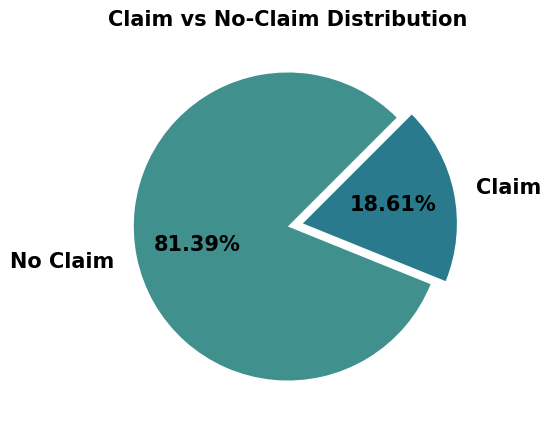

In [6]:
df['Claimed'] = (df['N_claims_year'] > 0).astype('int64')

colors = sns.color_palette("crest")[2:4]
fig, ax = plt.subplots(figsize=(6, 5))
df['Claimed'].value_counts().plot(kind = 'pie', ax=ax, labels = ['No Claim', 'Claim'], colors = colors,
                                   autopct='%1.2f%%', # inserir os porcentuais na 'fatia da pizza'
                                   explode = [0, 0.1], labeldistance=1.15, startangle=45,
                                   textprops={'fontsize':15, 'fontweight': 'bold'})
ax.set_title('Claim vs No-Claim Distribution', fontsize=15, fontweight='bold')
ax.set_ylabel('');
#fig.savefig('graph_pie_claim_perc.png')  

In [7]:
## Correct a probable mistyping in the ‘Distribution_channel’ column: 00/01/1900 --> 0
df['Distribution_channel'] = df['Distribution_channel'].astype(str).str.strip()
df['Distribution_channel'] = df['Distribution_channel'].replace('00/01/1900', 0)
df['Distribution_channel'] = pd.to_numeric(df['Distribution_channel'], errors='coerce')

In [8]:
df.dtypes

ID                               int64
Date_start_contract     datetime64[ns]
Date_last_renewal       datetime64[ns]
Date_next_renewal       datetime64[ns]
Date_birth              datetime64[ns]
Date_driving_licence    datetime64[ns]
Distribution_channel             int64
Seniority                        int64
Policies_in_force                int64
Max_policies                     int64
Max_products                     int64
Lapse                            int64
Date_lapse              datetime64[ns]
Payment                          int64
Premium                        float64
Cost_claims_year               float64
N_claims_year                    int64
N_claims_history                 int64
R_Claims_history               float64
Type_risk                        int64
Area                             int64
Second_driver                    int64
Year_matriculation               int64
Power                            int64
Cylinder_capacity                int64
Value_vehicle            

In [9]:
# Cria uma coluna 'Age' vazia antes do loop (logo após 'Date_birth')
pos = df.columns.get_loc('Date_birth')
df.insert(pos + 1, 'Age', np.nan)
# The age of the policyholder on the date of contract renewal
for row in range(df.shape[0]):
    birth = df.loc[row, 'Date_birth']
    ref = df.loc[row, 'Date_last_renewal']
    age = ref.year - birth.year
# If the person has not had birthday yet this year, subtract one year.
    if (birth.month, birth.day) > (ref.month, ref.day):
        age = age - 1
    df.loc[row, 'Age'] = age

In [10]:
time_drv_license = df['Date_last_renewal'].dt.year - df['Date_driving_licence'].dt.year
not_yet_birthday = (df['Date_last_renewal'].dt.month < df['Date_driving_licence'].dt.month) | \
((df['Date_last_renewal'].dt.month == df['Date_driving_licence'].dt.month) & (df['Date_last_renewal'].dt.day < df['Date_driving_licence'].dt.day))
time_drv_license = time_drv_license - not_yet_birthday.astype(int)
# Encontra a posição de Date_driving_licence
pos = df.columns.get_loc('Date_driving_licence')
# Insere a nova coluna ao lado da coluna Date_driving_licence
df.insert(pos + 1, 'Time_drv_license', time_drv_license)

In [11]:
df['Age'] = df['Age'].astype('int64')
df['Time_drv_license'] = df['Time_drv_license'].clip(lower=0)

In [12]:
df.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,59,1976-03-20,39,0,4,1,2,1,0,NaT,0,222.52,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,60,1976-03-20,40,0,4,1,2,1,0,NaT,0,213.78,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,61,1976-03-20,41,0,4,2,2,1,0,NaT,0,214.84,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,62,1976-03-20,42,0,4,2,2,1,0,NaT,0,216.99,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,61,1976-03-20,41,0,4,2,2,1,0,NaT,1,213.70,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0


In [13]:
print(df['Date_start_contract'].min())
df['Seniority'].max()

1980-10-25 00:00:00


np.int64(40)

In [14]:
df[df['Date_start_contract'] == '1980-10-25']

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
25595,12566,1980-10-25,2016-10-25,2017-10-25,1951-09-25,65,1970-11-25,45,0,39,1,1,1,0,NaT,0,57.06,0.0,0,3,0.08,3,1,0,1969,25,767,270.46,4,P,3.475,635,0
25596,12566,1980-10-25,2017-10-25,2018-10-25,1951-09-25,66,1970-11-25,46,0,39,1,1,1,0,NaT,0,58.78,0.0,0,3,0.08,3,1,0,1969,25,767,270.46,4,P,3.475,635,0
25597,12566,1980-10-25,2018-10-25,2019-10-25,1951-09-25,67,1970-11-25,47,0,39,1,1,1,0,NaT,0,60.84,0.0,0,3,0.08,3,1,0,1969,25,767,270.46,4,P,3.475,635,0


In [15]:
df_int = df.select_dtypes(include = 'int64').copy()
df_float = df.select_dtypes(include = 'float64').copy()
df_float['Claimed'] = df_int['Claimed']

In [16]:
display(df_int.shape)
df_int.describe()

(105555, 21)

,ID,Age,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,N_claims_year,N_claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,N_doors,Weight,Claimed
count,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000
mean,26271.286789,46.827275,24.278405,0.451310,6.696604,1.455649,1.837232,1.065842,0.221837,0.319180,0.394695,2.751760,2.721804,0.273895,0.123708,2004.728038,92.682611,1617.759367,4.067898,1191.262422,0.186121
std,15388.309324,12.839834,12.476962,0.497626,6.263911,0.928427,1.155536,0.267807,0.464858,0.466161,1.105018,3.881621,0.614835,0.445958,0.329250,6.767037,37.012645,604.697382,1.511839,458.081834,0.389206
min,1.000000,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1950.000000,0.000000,49.000000,0.000000,43.000000,0.000000
25%,12925.000000,37.000000,14.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2001.000000,75.000000,1390.000000,3.000000,1043.000000,0.000000
50%,26082.000000,46.000000,23.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,2005.000000,90.000000,1598.000000,5.000000,1205.000000,0.000000
75%,39754.000000,56.000000,34.000000,1.000000,9.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.000000,3.000000,1.000000,0.000000,2008.000000,110.000000,1910.000000,5.000000,1388.000000,0.000000
max,53502.000000,98.000000,74.000000,1.000000,40.000000,17.000000,17.000000,4.000000,7.000000,1.000000,25.000000,52.000000,4.000000,1.000000,1.000000,2018.000000,580.000000,7480.000000,6.000000,7300.000000,1.000000


In [17]:
df[df['N_claims_year'] == 25]

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
45125,21987,2014-12-19,2015-12-19,2016-12-19,1972-06-06,43,2002-04-03,13,0,12,4,6,2,0,NaT,0,414.85,353.28,25,52,2.78,2,0,0,2001,116,2286,25908.6,2,D,5.899,1609,1


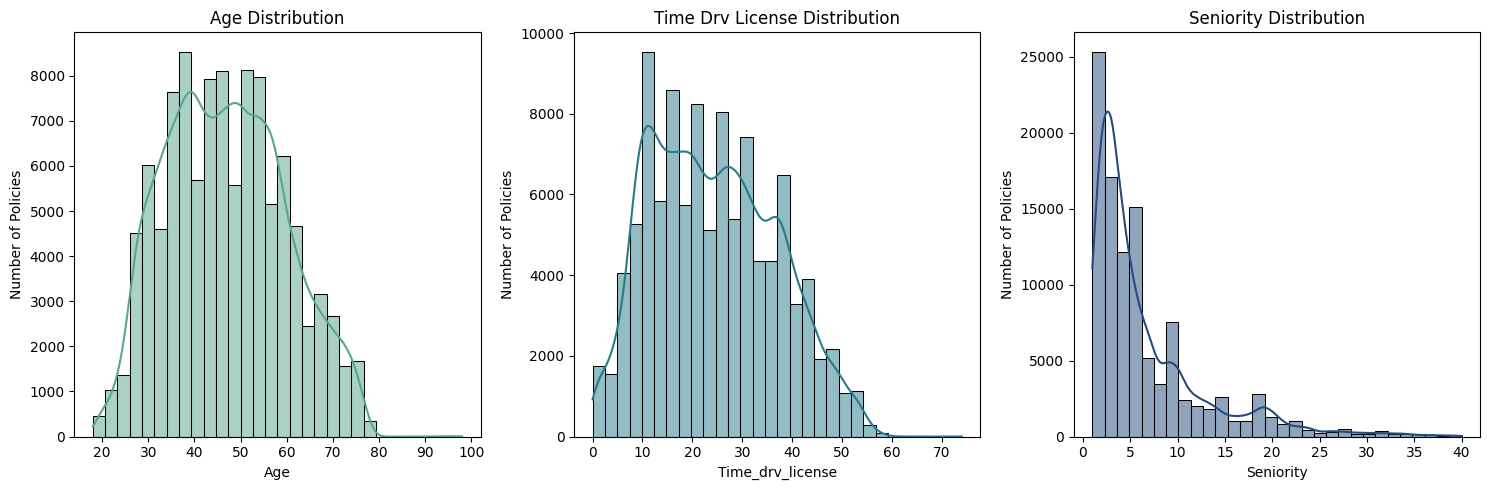

In [18]:
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))

cols = ['Age', 'Time_drv_license', 'Seniority']

for (i, col) in enumerate(cols):
    sns.histplot(df_int[col], bins=30, kde = True, ax=ax[i], color=sns.color_palette("crest")[2*i+1])
    ax[i].set(title = '{} Distribution'.format(col.replace('_', ' ')).title(), xlabel = col, ylabel = 'Number of Policies')

plt.tight_layout()


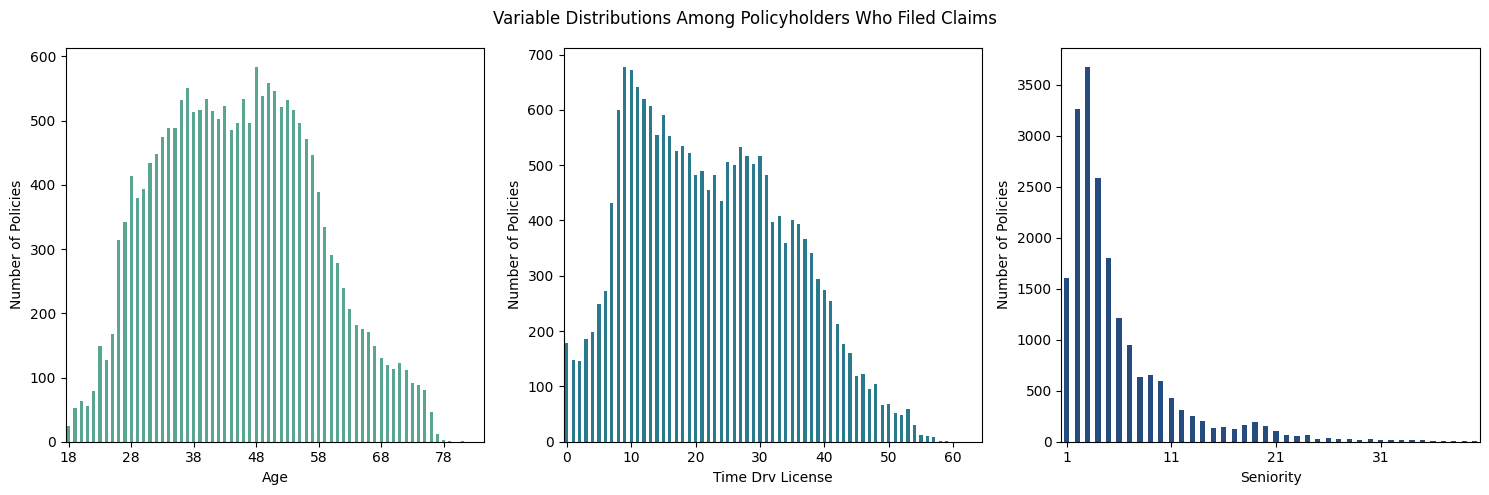

In [19]:
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))

cols = ['Age', 'Time_drv_license', 'Seniority']

for (i, col) in enumerate(cols):
    var_ct = pd.crosstab(index = df_int[col], columns = df_int['Claimed'])
    var_ct[1].plot(kind = 'bar', color=sns.color_palette("crest")[2*i+1], ax = ax[i])
    plt.suptitle('Variable Distributions Among Policyholders Who Filed Claims')
    ax[i].set(xlabel = '{}'.format(col.replace('_', ' ').title()), ylabel = 'Number of Policies')
    ax[i].xaxis.set_major_locator(MultipleLocator(10))
    ax[i].xaxis.set_tick_params(labelrotation=0)
    
plt.tight_layout()
#fig.savefig('graph_overview_continous.png')


In [20]:
var_ct = pd.crosstab(index = df_int['Seniority'], columns = df_int['Claimed'])
var_ct
df_int['Time_drv_license'].min()


np.int64(0)

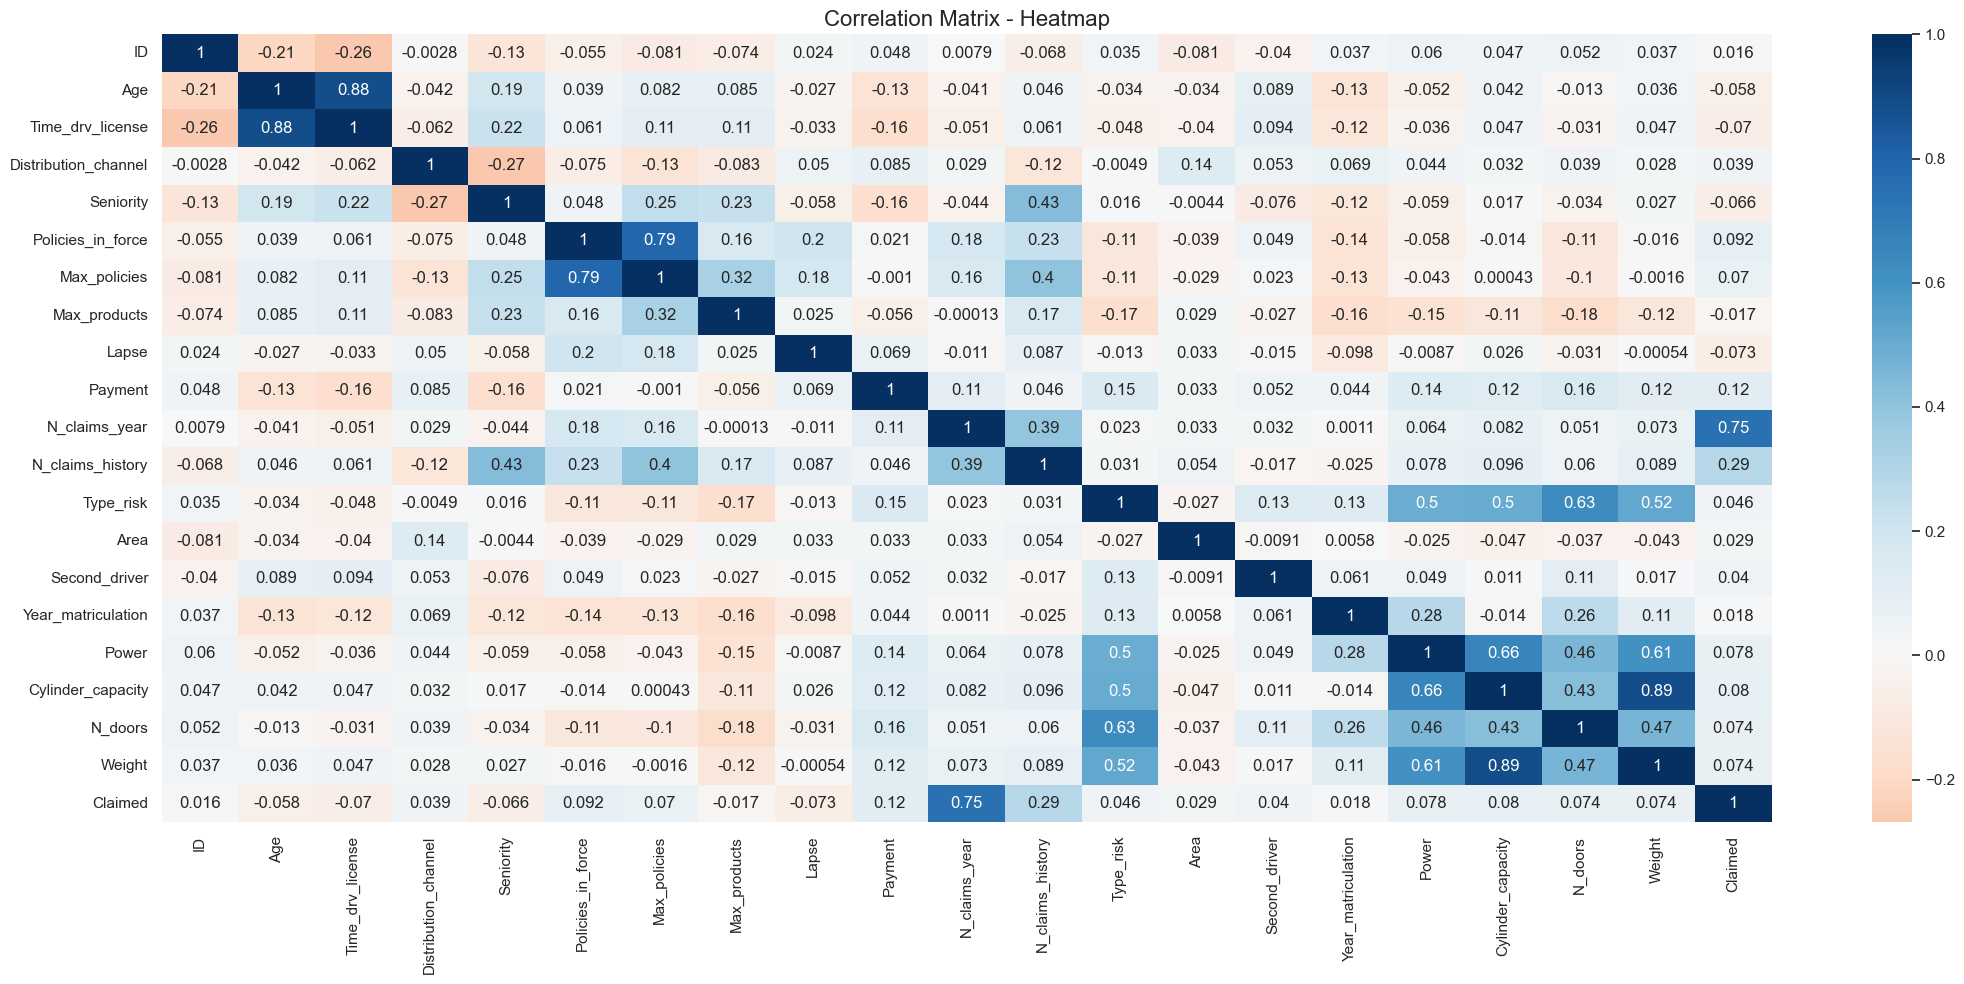

In [21]:
heatmap_corr(df_int)

In [22]:
correlacoes = df_int.corrwith(df_int['Claimed']).sort_values(ascending=False)

display(correlacoes)

Claimed                 1.000000
N_claims_year           0.746924
N_claims_history        0.289861
Payment                 0.116151
Policies_in_force       0.092033
Cylinder_capacity       0.080067
Power                   0.077809
N_doors                 0.074257
Weight                  0.073740
Max_policies            0.070478
Type_risk               0.046140
Second_driver           0.039673
Distribution_channel    0.039356
Area                    0.028604
Year_matriculation      0.018388
ID                      0.016338
Max_products           -0.016955
Age                    -0.057661
Seniority              -0.065927
Time_drv_license       -0.069789
Lapse                  -0.073372
dtype: float64

In [23]:
# Statistical significance test (ANOVA/t-test)
from scipy.stats import ttest_ind  

claim0 = df_int[df_int['Claimed'] == 0]
claim1 = df_int[df_int['Claimed'] == 1]

ttest_results = {}
for col in df_int.columns:
    if col != 'Claimed':
        stat, pval = ttest_ind(claim0[col], claim1[col], equal_var=False)
        ttest_results[col] = pval

pd.Series(ttest_results).sort_values()

N_claims_year            0.000000e+00
N_claims_history         0.000000e+00
Payment                 6.612136e-278
Cylinder_capacity       1.378841e-203
Weight                  3.242782e-197
N_doors                 5.924631e-182
Power                   4.134523e-166
Policies_in_force       1.159891e-140
Lapse                   3.647776e-134
Seniority               8.386605e-126
Time_drv_license        9.629334e-118
Max_policies             5.511134e-89
Age                      1.294381e-81
Type_risk                2.082007e-70
Distribution_channel     4.310522e-37
Second_driver            1.879750e-33
Area                     9.976266e-20
Year_matriculation       7.995420e-12
Max_products             5.105464e-09
ID                       7.636086e-08
dtype: float64

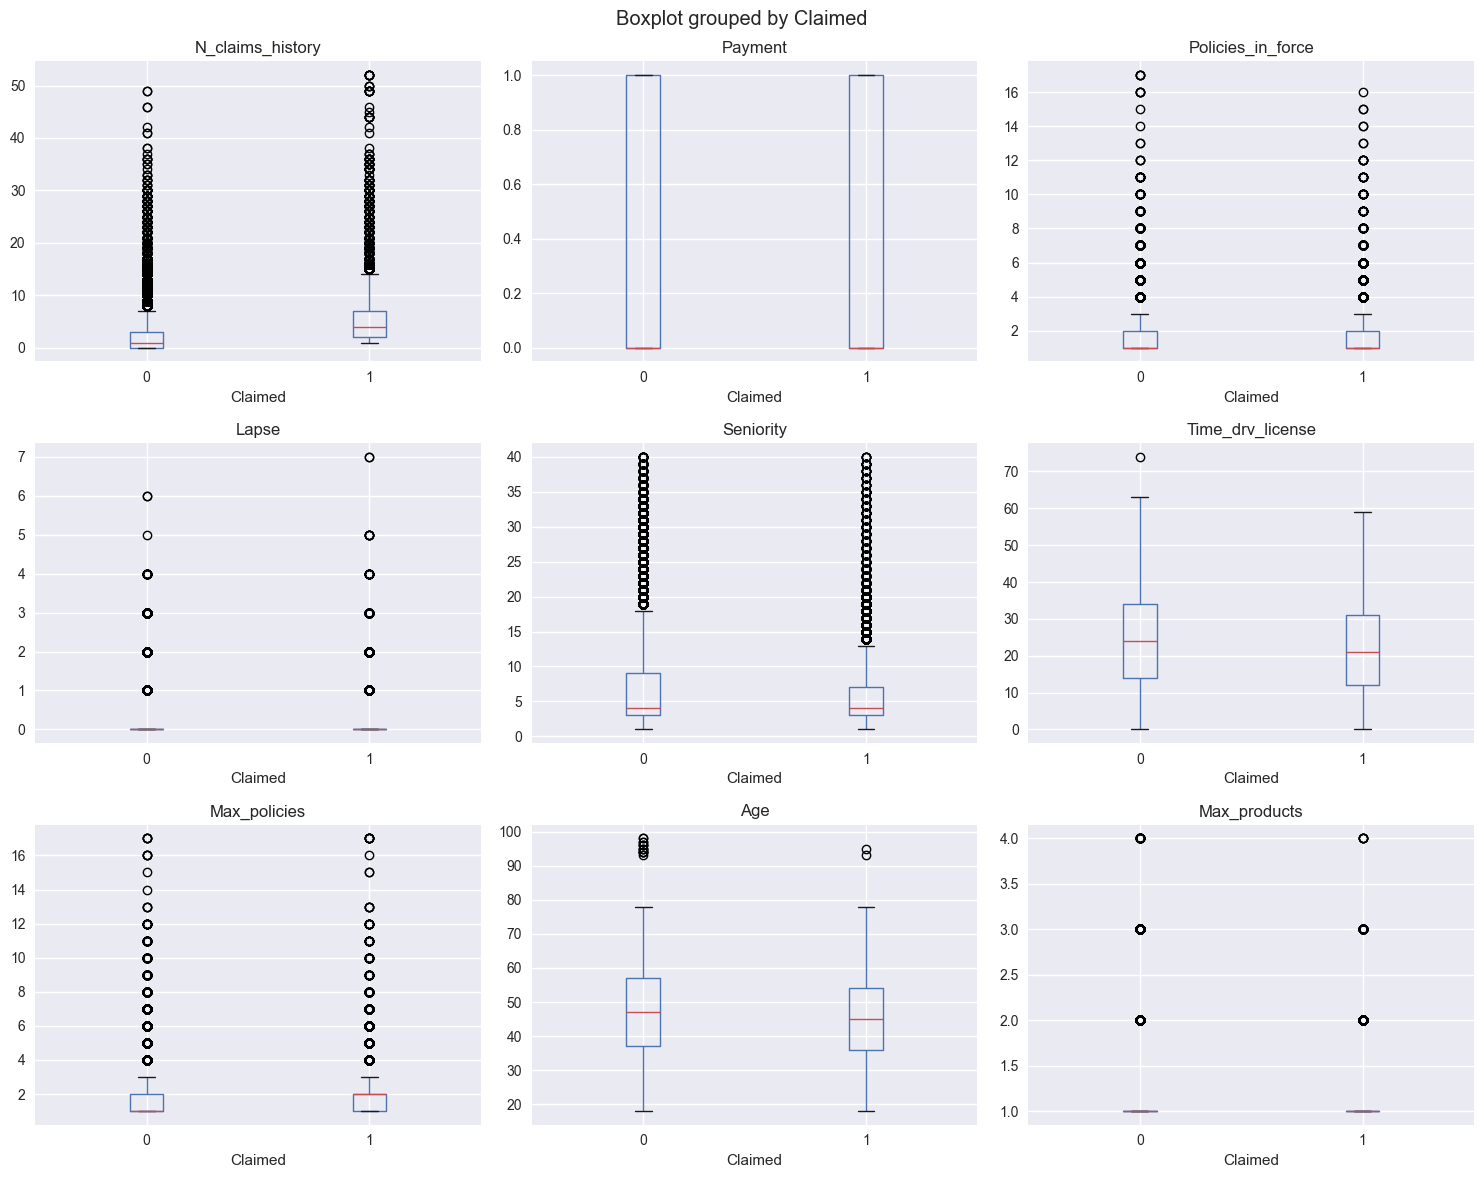

In [24]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(15, 12))

cols_int = ['N_claims_history','Payment', 'Policies_in_force', 'Lapse', 'Seniority', 'Time_drv_license', 'Max_policies', 'Age', 'Max_products']

ax = ax.flatten() # achata o array ax, transforma o array 2D (2 linhas x 3 colunas) em um array 1D - vetor (6 itens).

for i, col in enumerate(cols_int):
    df_int.boxplot(column=col, by='Claimed', ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('Claimed')
    
plt.tight_layout()

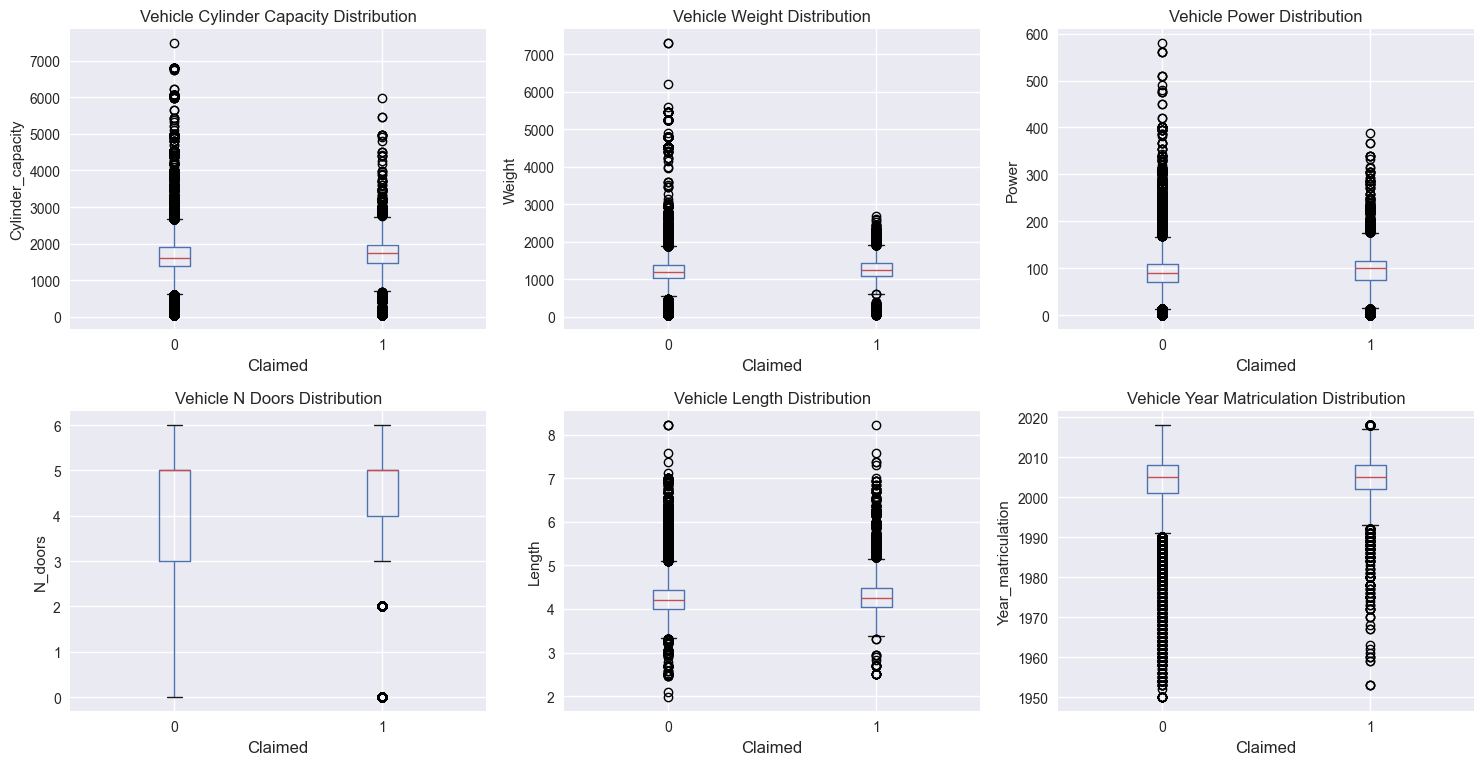

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 8))
ax = ax.flatten()

cols = ['Cylinder_capacity', 'Weight', 'Power', 'N_doors', 'Length', 'Year_matriculation']

for i, col in enumerate(cols):
    df.boxplot(column=col, by='Claimed', ax=ax[i])
    ax[i].set_title('Vehicle {} Distribution'.format(col.replace('_', ' ').title()))
    ax[i].set_xlabel('Claimed', fontsize=12)
    ax[i].set_ylabel(col)
    plt.suptitle('')
plt.tight_layout()
fig.savefig('boxplot_vehicle_var.png')
    

7480


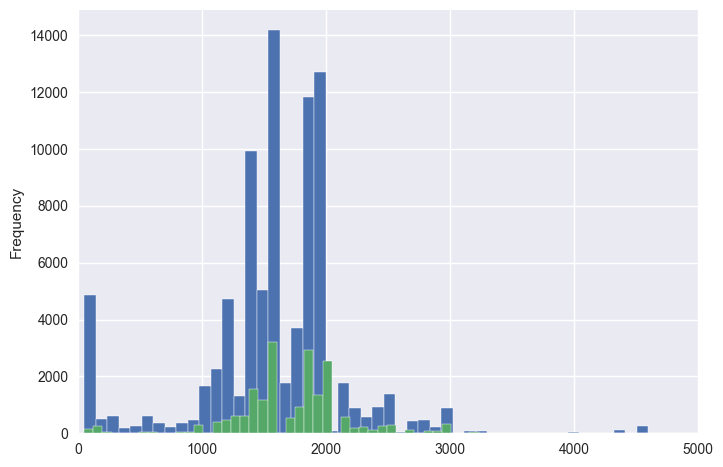

In [26]:
df_int.groupby('Claimed')['Cylinder_capacity'].plot(kind = 'hist', bins = 80, xlim=[0, 5000]);

print(df['Cylinder_capacity'].max())

C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\1901299235.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2*i + 1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[2*i + 1].get_yticks()])
C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\1901299235.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2*i + 1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[2*i + 1].get_yticks()])
C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\1901299235.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2*i + 1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[2*i + 1].get_yticks()])


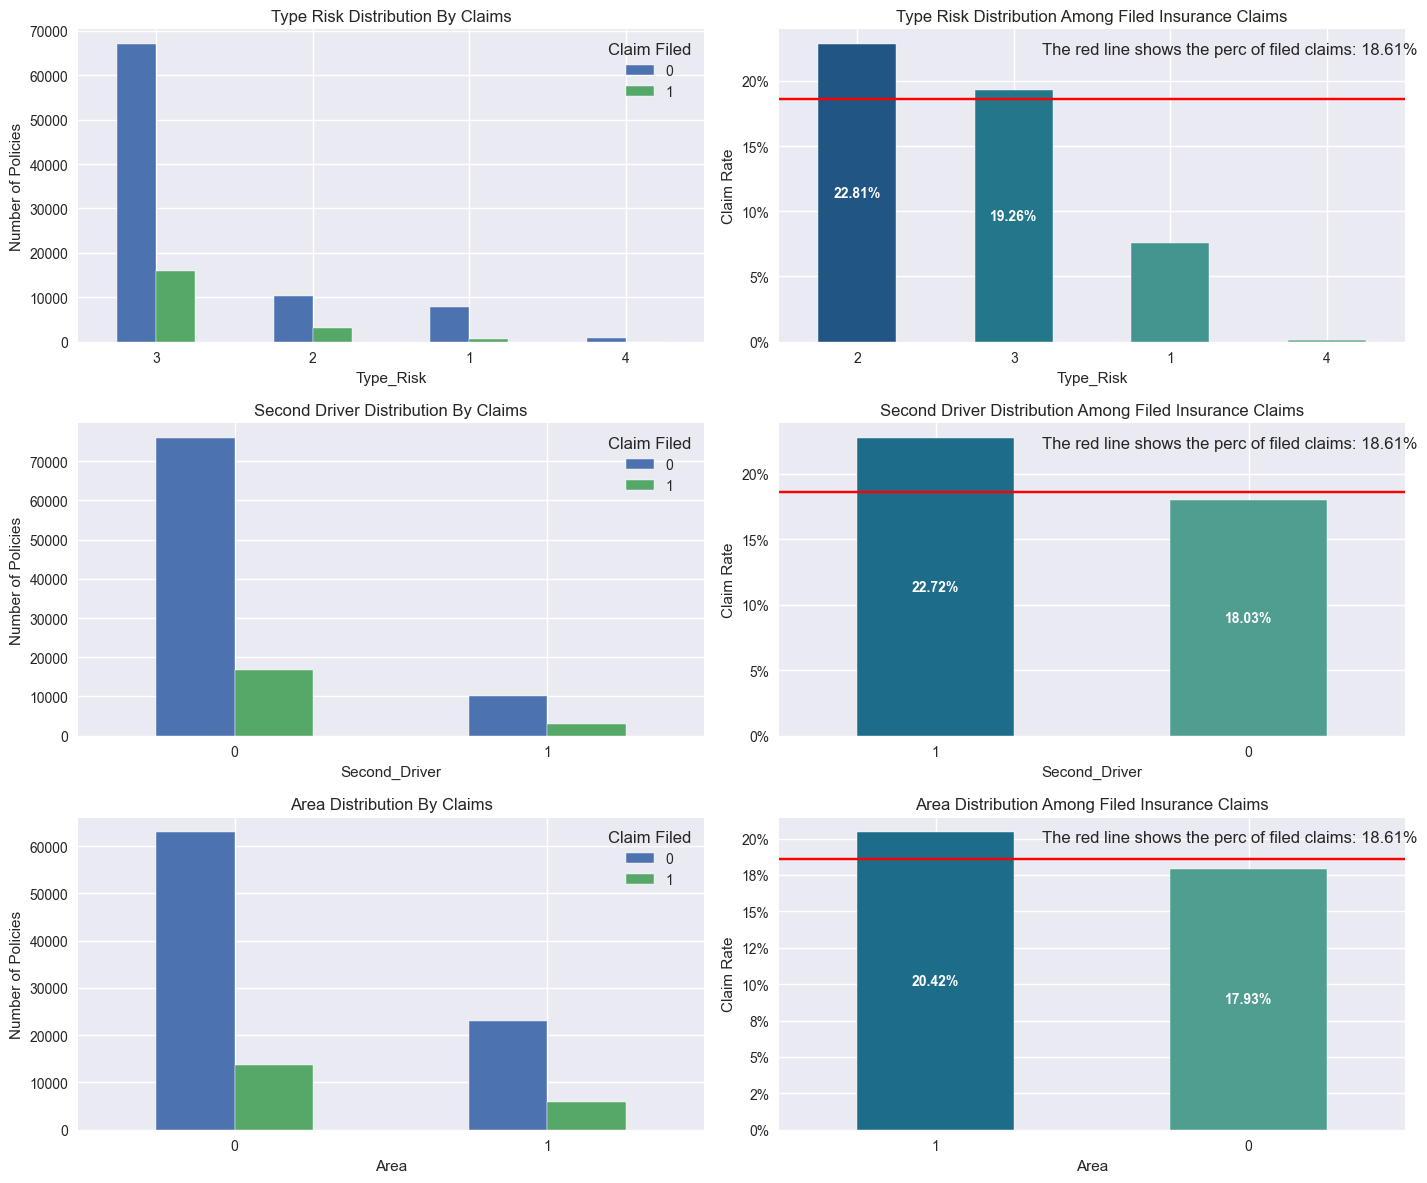

In [27]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(15, 12))
ax = ax.flatten()

cols = ['Type_risk', 'Second_driver', 'Area']

for (i, col) in enumerate(cols):
    var_ct = pd.crosstab(index = df_int[col], columns = df_int['Claimed'])
    var_ct = var_ct.sort_values(by=1, ascending=False)
    var_ct.plot(kind = 'bar', ax = ax[2*i])
    ax[2*i].set(title = '{} Distribution by Claims'.format(col.replace('_', ' ')).title(), xlabel = col.title(), ylabel = 'Number of Policies')
    ax[2*i].legend(title='Claim Filed')
    ax[2*i].xaxis.set_tick_params(labelrotation=0);
    
    colors = sns.color_palette('crest', n_colors=len(df_int[col].unique()))[::-1] # Paleta invertida: mais escuro = maior incidência
    df_int.groupby(col)['Claimed'].mean().sort_values(ascending=False).plot(kind = 'bar', color = colors, ax = ax[2*i + 1])
    ax[2*i + 1].set(title = '{} Distribution Among Filed Insurance Claims'.format(col.replace('_', ' ')).title(), xlabel = col.title(), ylabel = 'Claim Rate')
    ax[2*i + 1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[2*i + 1].get_yticks()])
    ax[2*i + 1].xaxis.set_tick_params(labelrotation=0)
    ax[2*i + 1].axhline(color='red', y = df_int['Claimed'].mean());
    ax[2*i + 1].text(transform=ax[2*i + 1].transAxes, 
                     s = 'The red line shows the perc of filed claims: {}%'.format(round(df_int['Claimed'].mean()*100, 2)), x =0.42, y=0.92)
    
    for j, p in enumerate(ax[2*i + 1].patches):
        if j < 2:
            height = p.get_height()
            ax[2*i + 1].text(p.get_x() + p.get_width()/2,  # centro da barra
                             height/2,                      # posição vertical (meio da barra)
                             f'{height*100:.2f}%',          # formato percentual
                             ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    
plt.tight_layout()

In [28]:
df_int[df_int['Claimed'] ==1].describe()

,ID,Age,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,N_claims_year,N_claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,N_doors,Weight,Claimed
count,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.000000,19646.0
mean,26797.021378,45.279090,22.457549,0.492263,5.833045,1.634328,2.007533,1.056347,0.150514,0.432404,2.120635,5.104551,2.781126,0.300570,0.151023,2004.988242,98.704876,1719.004123,4.302657,1261.898605,1.0
std,15132.943260,12.446063,12.137702,0.499953,5.391945,1.137550,1.362944,0.247628,0.442346,0.495422,1.703112,4.933001,0.486459,0.458518,0.358081,5.630672,32.911411,483.710106,1.177986,331.930404,0.0
min,7.000000,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1953.000000,0.000000,49.000000,0.000000,55.000000,1.0
25%,14019.750000,36.000000,12.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000,2002.000000,75.000000,1461.000000,4.000000,1095.000000,1.0
50%,26623.000000,45.000000,21.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,4.000000,3.000000,0.000000,0.000000,2005.000000,100.000000,1753.000000,5.000000,1259.000000,1.0
75%,39499.750000,54.000000,31.000000,1.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,7.000000,3.000000,1.000000,0.000000,2008.000000,115.000000,1974.000000,5.000000,1422.000000,1.0
max,53459.000000,95.000000,59.000000,1.000000,40.000000,16.000000,17.000000,4.000000,7.000000,1.000000,25.000000,52.000000,4.000000,1.000000,1.000000,2018.000000,388.000000,5967.000000,6.000000,2688.000000,1.0


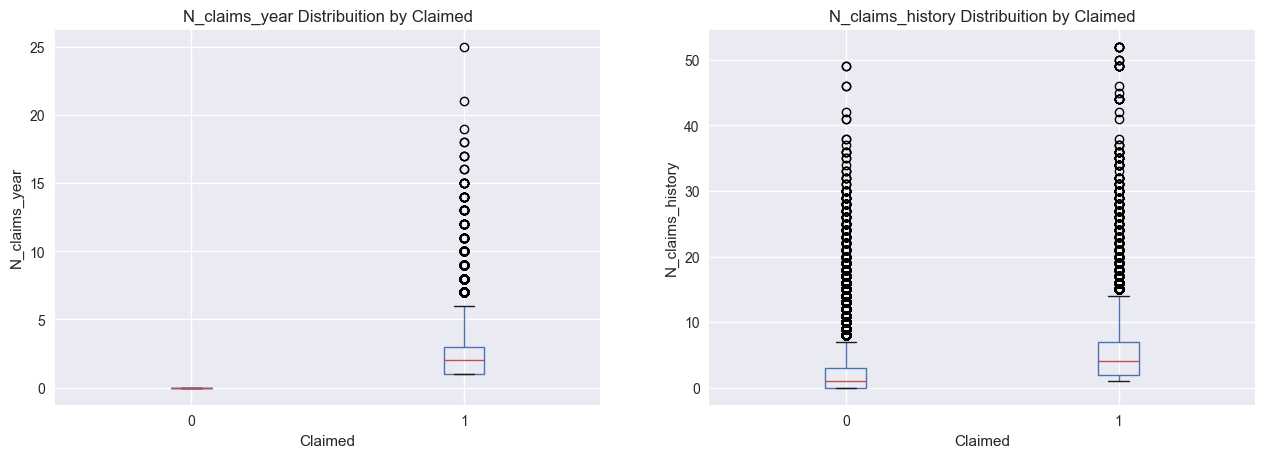

In [29]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(ncols = 2, figsize=(15, 5))

df_int.boxplot(column='N_claims_year', by='Claimed', ax=ax[0])
df_int.boxplot(column='N_claims_history', by='Claimed', ax=ax[1])
plt.suptitle('')
ax[0].set_title('N_claims_year Distribuition by Claimed')
ax[0].set_ylabel('N_claims_year')
ax[1].set_title('N_claims_history Distribuition by Claimed')
ax[1].set_ylabel('N_claims_history');

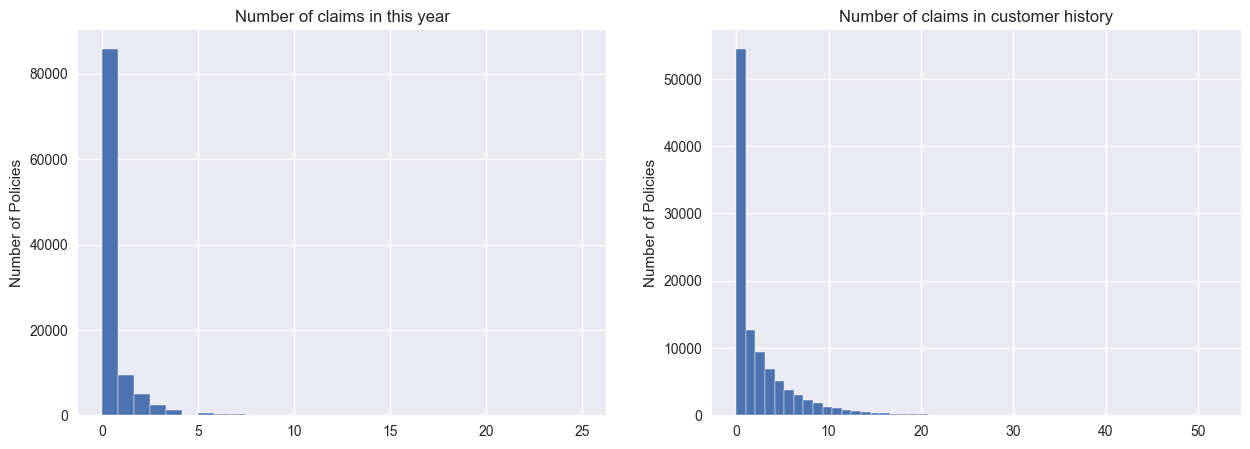

In [30]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(ncols = 2, figsize=(15, 5))

df_int['N_claims_year'].plot(kind = 'hist', bins=30, ax=ax[0])
df_int['N_claims_history'].plot(kind = 'hist', bins=50, ax=ax[1])
ax[0].set_title('Number of claims in this year')
ax[0].set_ylabel('Number of Policies')
ax[1].set_title('Number of claims in customer history')
ax[1].set_ylabel('Number of Policies');

In [31]:
display(df_float.describe())
df_float.head()

,Premium,Cost_claims_year,R_Claims_history,Value_vehicle,Length,Claimed
count,105555.000000,105555.000000,105555.000000,105555.000000,95226.000000,105555.000000
mean,315.892557,153.557305,0.425194,18413.657243,4.252007,0.186121
std,140.927969,1477.112362,0.714883,9135.074235,0.393220,0.389206
min,40.140000,0.000000,0.000000,270.460000,1.978000,0.000000
25%,241.610000,0.000000,0.000000,13127.210000,3.999000,0.000000
50%,292.280000,0.000000,0.080000,17608.770000,4.230000,0.000000
75%,361.640000,0.000000,0.590000,22595.000000,4.443000,0.000000
max,2993.340000,260853.240000,26.070000,220675.800000,8.218000,1.000000


,Premium,Cost_claims_year,R_Claims_history,Value_vehicle,Length,Claimed
0,222.52,0.0,0.0,7068.0,NaN,0
1,213.78,0.0,0.0,7068.0,NaN,0
2,214.84,0.0,0.0,7068.0,NaN,0
3,216.99,0.0,0.0,7068.0,NaN,0
4,213.70,0.0,0.0,7068.0,NaN,0


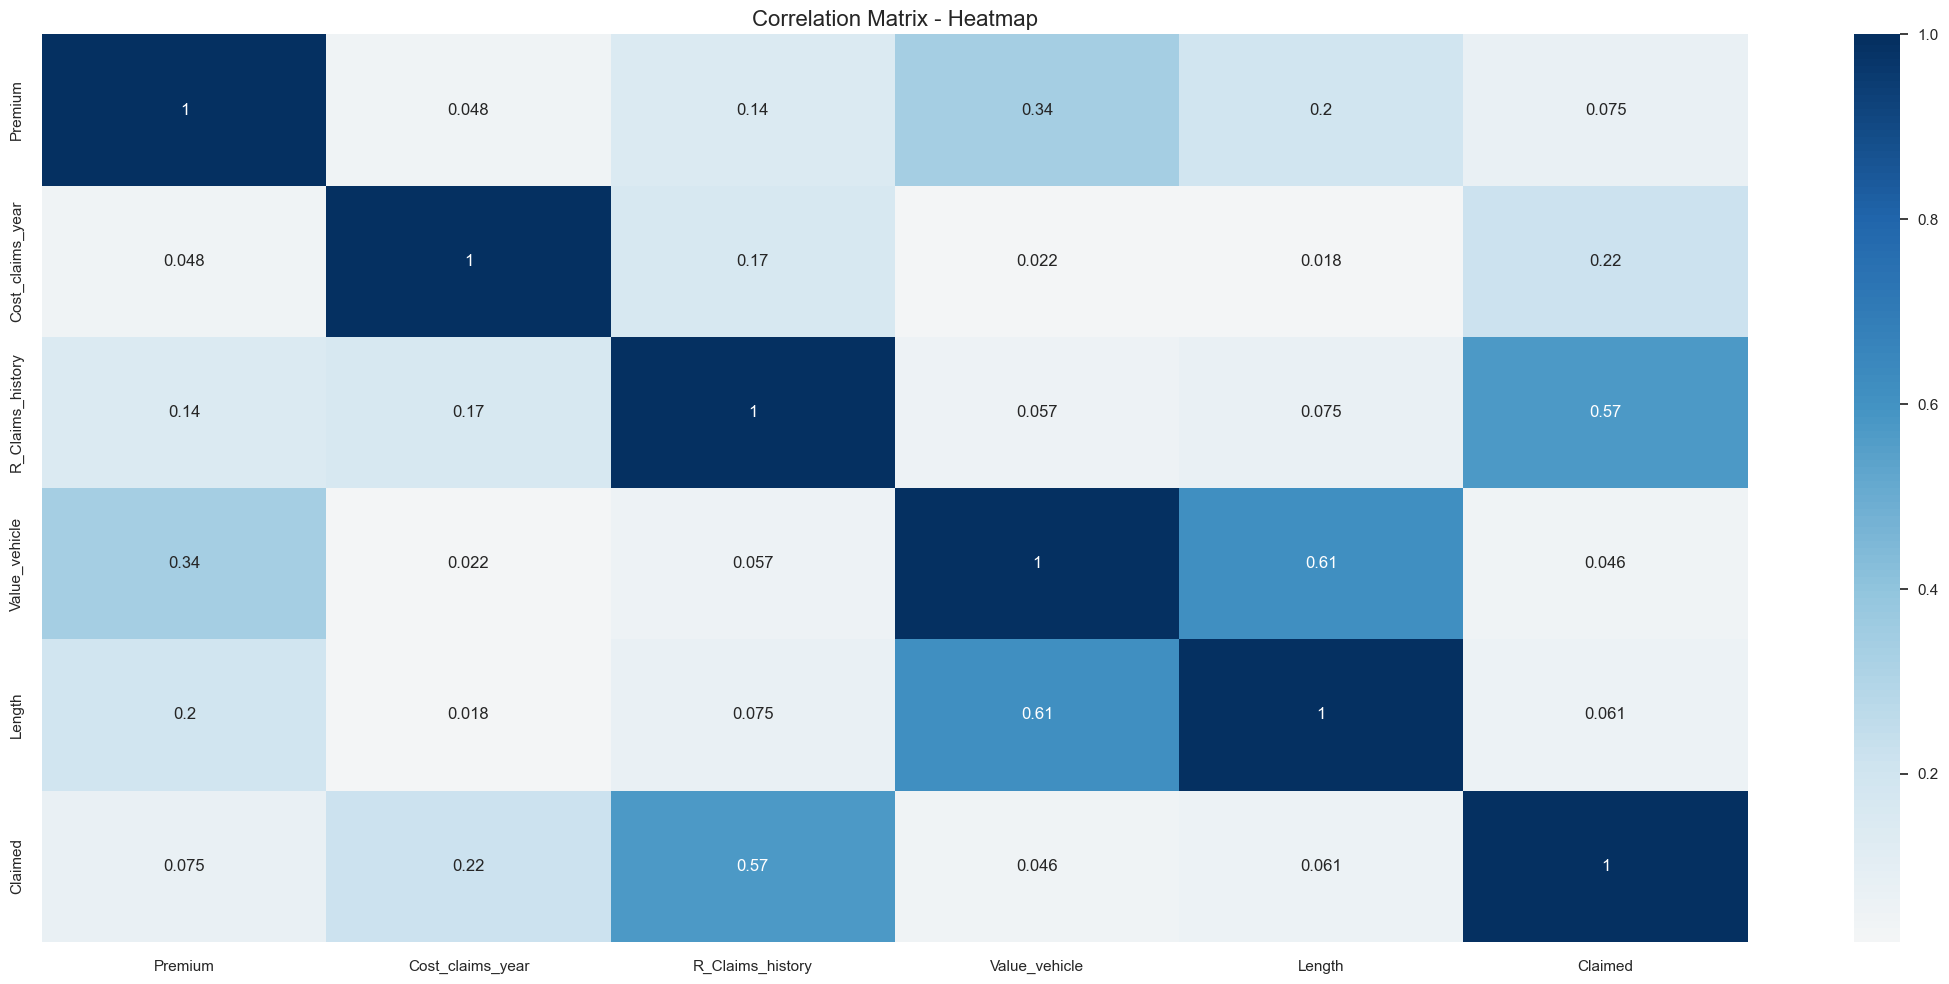

In [32]:
heatmap_corr(df_float)

In [33]:
correlacoes_2 = df_float.corrwith(df_int['Claimed']).sort_values(ascending=False)

display(correlacoes_2)

Claimed             1.000000
R_Claims_history    0.575965
Cost_claims_year    0.217391
Premium             0.105799
Value_vehicle       0.072309
Length              0.060599
dtype: float64

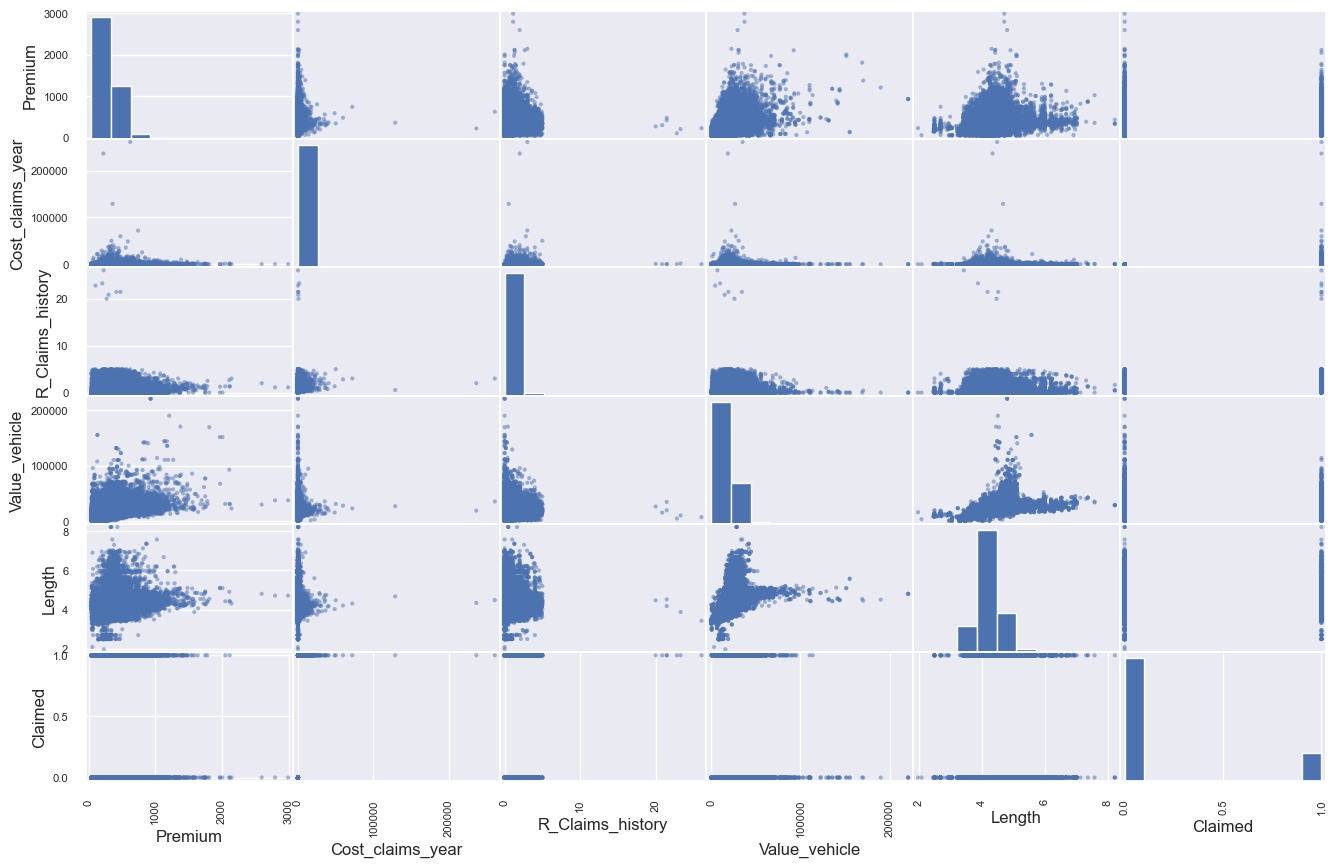

In [34]:
pd.plotting.scatter_matrix(df_float, figsize=[16, 10]);  

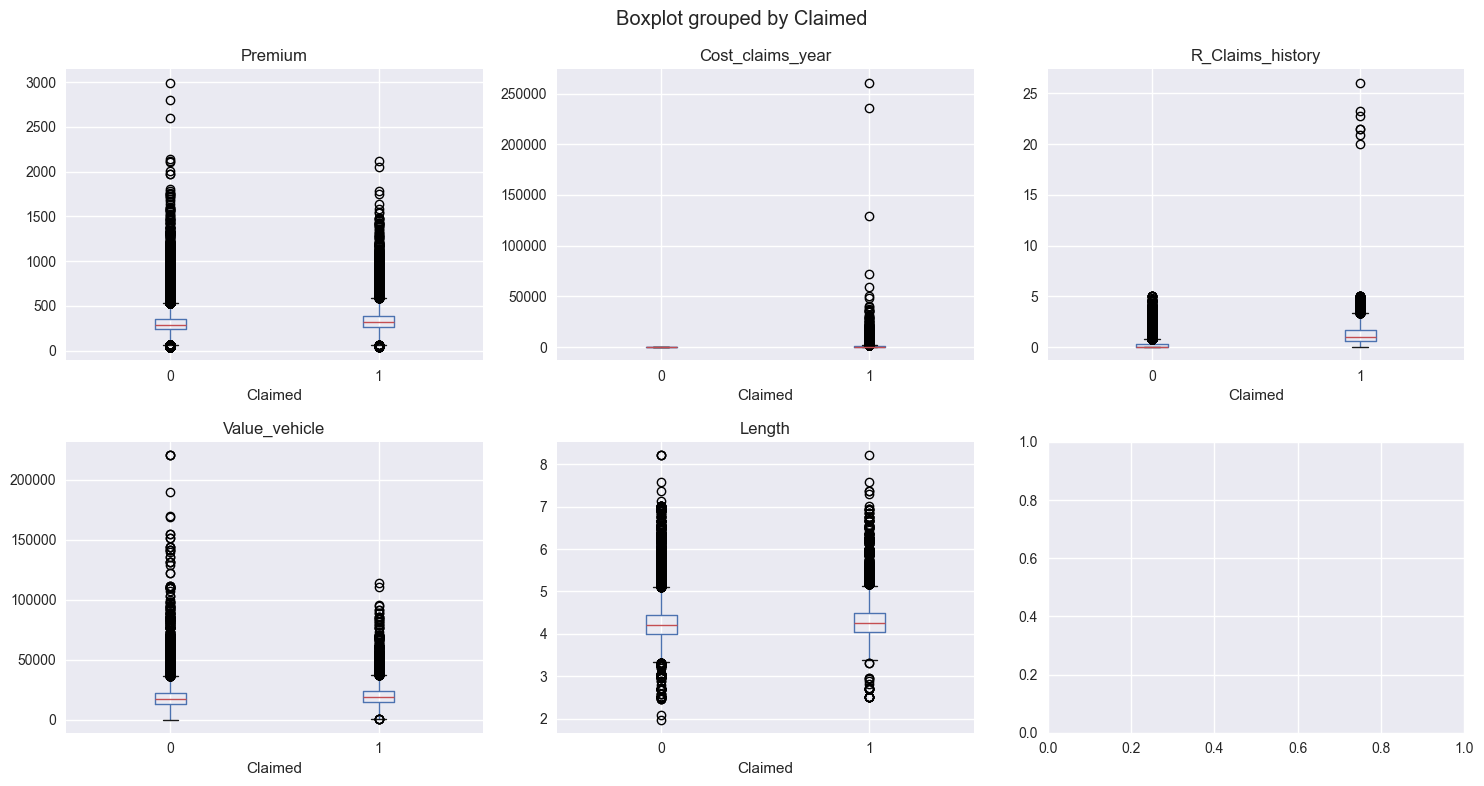

In [35]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 8))

ax = ax.flatten() # achata o array ax, transforma o array 2D (2 linhas x 3 colunas) em um array 1D - vetor (6 itens).
for i, col in enumerate(df_float.columns):
    if col == 'Claimed':
        continue
    df_float.boxplot(column=col, by='Claimed', ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()

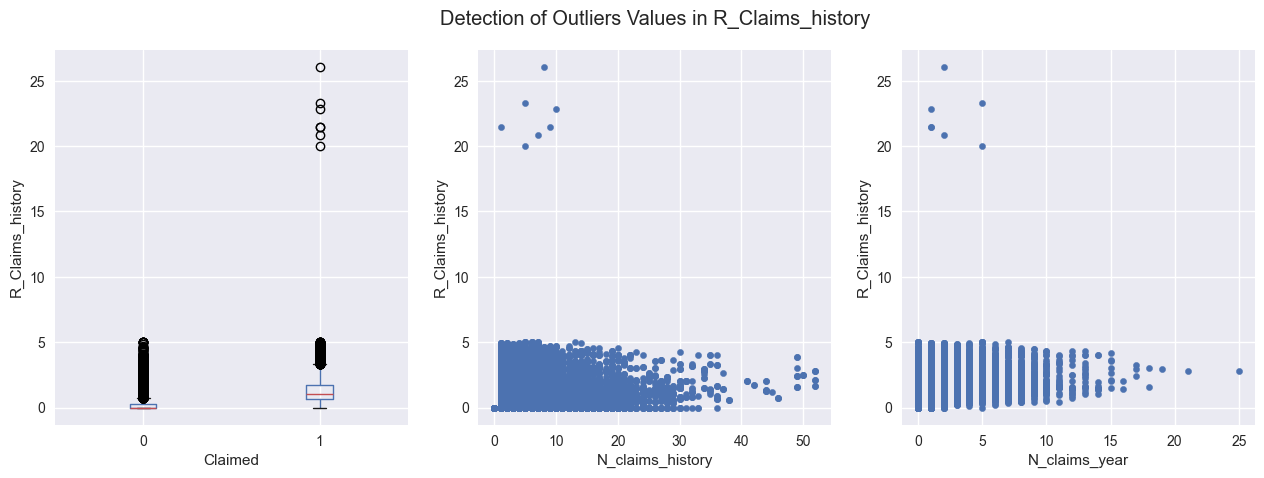

In [36]:
# Erneut Erstellung der Grafiken zur Verwendung im Projektbericht
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
df_float.boxplot(column='R_Claims_history', by='Claimed', ax=ax[0])
ax[0].set(title = '', xlabel = 'Claimed', ylabel = 'R_Claims_history')
df.plot(kind = 'scatter', x = 'N_claims_history', y = 'R_Claims_history', ax=ax[1])
df.plot(kind = 'scatter', x = 'N_claims_year', y = 'R_Claims_history', ax=ax[2])
plt.suptitle('Detection of Outliers Values in R_Claims_history');
fig.savefig('graph_outlier_rclaimhistory.png')

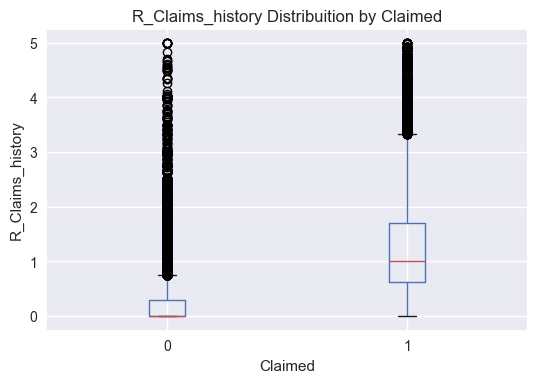

In [37]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(6, 4))

df_float[df_float['R_Claims_history'] < 5].boxplot(column='R_Claims_history', by='Claimed', ax=ax)
plt.suptitle('')
ax.set_title('R_Claims_history Distribuition by Claimed')
ax.set_ylabel('R_Claims_history');

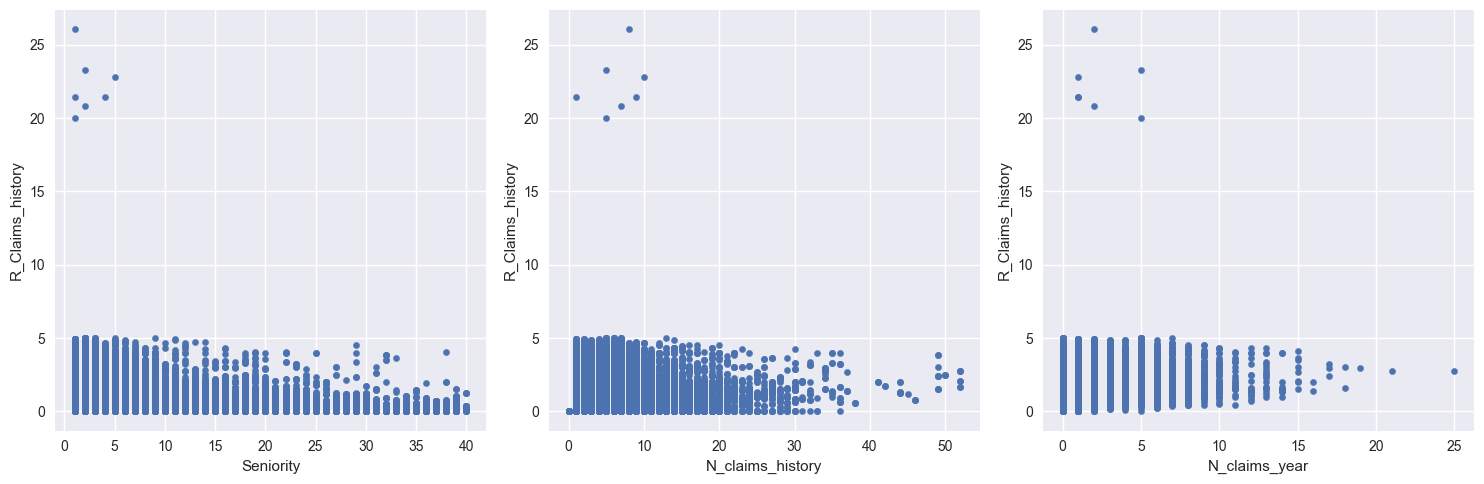

In [38]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))

ax = ax.flatten()
df.plot(kind = 'scatter', x = 'Seniority', y = 'R_Claims_history', ax=ax[0])
df.plot(kind = 'scatter', x = 'N_claims_history', y = 'R_Claims_history', ax=ax[1])
df.plot(kind = 'scatter', x = 'N_claims_year', y = 'R_Claims_history', ax=ax[2])
plt.tight_layout()

In [39]:
#Replace outlier values for the ratio N_claims_history/Seniority, limited to 5. Values of R_Claims_history higher than 5 are outliers
mask = df['R_Claims_history'] > 5
df.loc[mask, 'R_Claims_history'] = np.minimum(df.loc[mask, 'N_claims_history'] / df.loc[mask, 'Seniority'], 5)

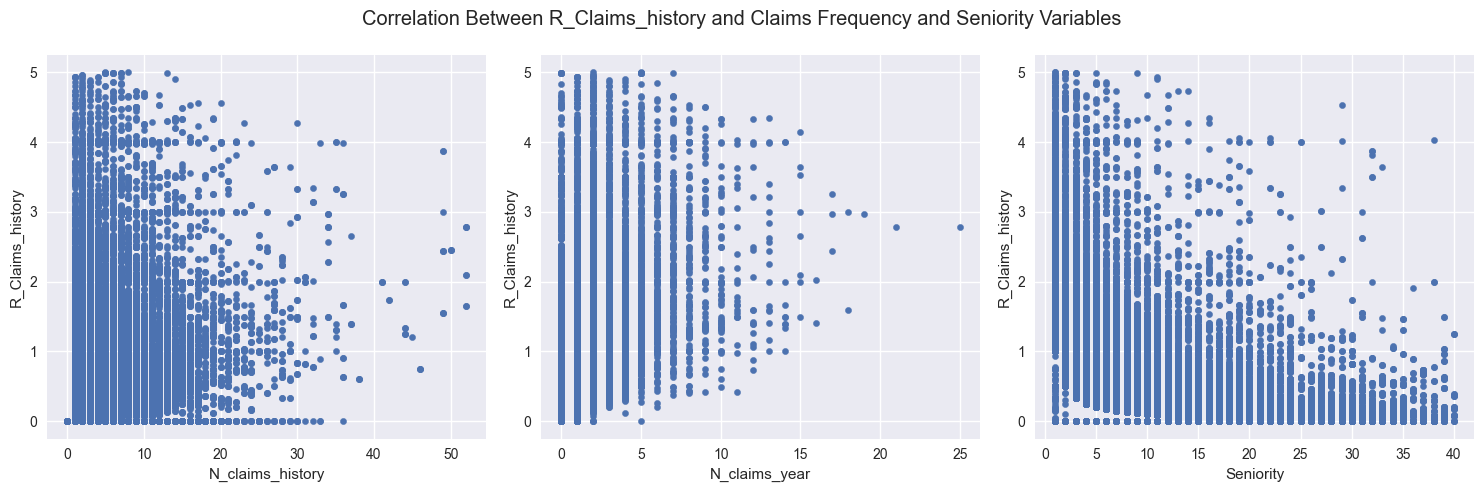

In [40]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))

ax = ax.flatten()
df.plot(kind = 'scatter', x = 'N_claims_history', y = 'R_Claims_history', ax=ax[0])
df.plot(kind = 'scatter', x = 'N_claims_year', y = 'R_Claims_history', ax=ax[1])
df.plot(kind = 'scatter', x = 'Seniority', y = 'R_Claims_history', ax=ax[2])
plt.suptitle('Correlation Between R_Claims_history and Claims Frequency and Seniority Variables')
plt.tight_layout()
fig.savefig('scatter_rclaimhist_nclaims_seniority.png')

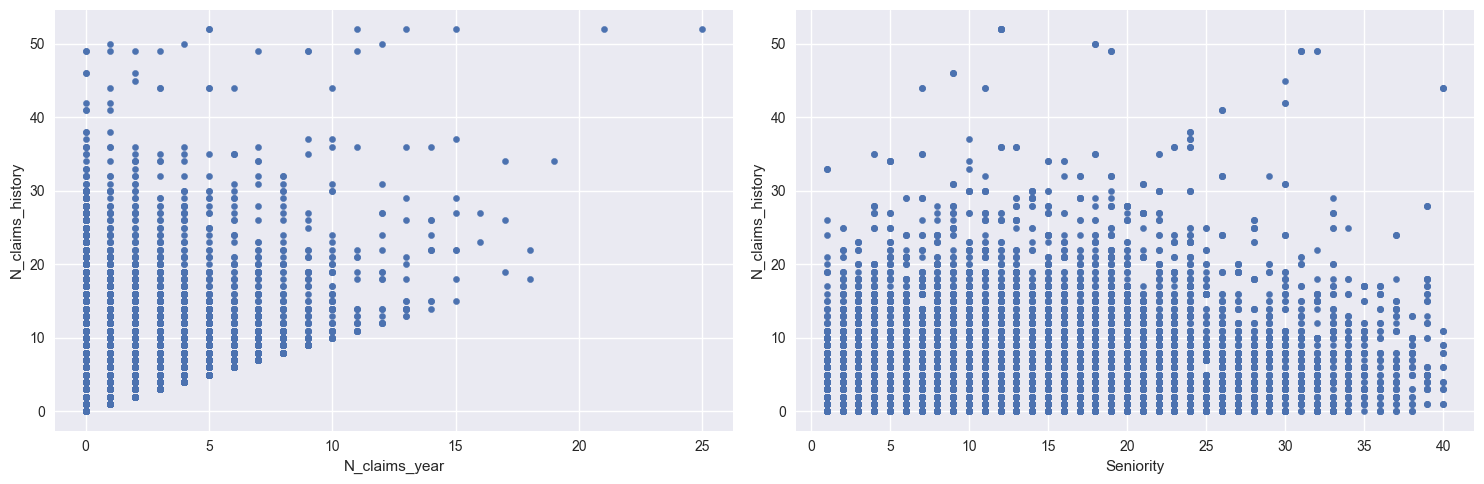

In [41]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(ncols = 2, figsize=(15, 5))

ax = ax.flatten()
df.plot(kind = 'scatter', x = 'N_claims_year', y = 'N_claims_history', ax=ax[0])
df.plot(kind = 'scatter', x = 'Seniority', y = 'N_claims_history', ax=ax[1])
plt.tight_layout()

In [42]:
df[df['Type_fuel'].isna()].head(5)

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
233,118,2014-09-01,2016-09-01,2017-09-01,1954-11-01,61,1973-11-01,42,0,6,2,2,2,0,2017-09-01,0,90.68,0.0,0,0,0.0,1,0,0,1980,0,124,3699.0,0,NaN,NaN,117,0
234,118,2014-09-01,2017-09-01,2018-09-01,1954-11-01,62,1973-11-01,43,0,6,2,2,2,1,2017-09-01,0,91.12,0.0,0,0,0.0,1,0,0,1980,0,124,3699.0,0,NaN,NaN,117,0
316,164,2014-12-01,2015-12-01,2016-12-01,1940-06-27,75,1968-10-01,47,1,5,1,1,1,0,2017-12-01,0,106.23,0.0,0,0,0.0,1,0,0,1988,0,200,3999.0,0,NaN,NaN,149,0
317,164,2014-12-01,2016-12-01,2017-12-01,1940-06-27,76,1968-10-01,48,1,5,1,1,1,0,2017-12-01,0,105.28,0.0,0,0,0.0,1,0,0,1988,0,200,3999.0,0,NaN,NaN,149,0
318,164,2014-12-01,2017-12-01,2018-12-01,1940-06-27,77,1968-10-01,49,1,5,1,1,1,1,2017-12-01,0,105.80,0.0,0,0,0.0,1,0,0,1988,0,200,3999.0,0,NaN,NaN,149,0


In [43]:
var_ct = pd.crosstab(index = df['Claimed'], columns = df['Type_fuel'])
var_ct = var_ct.sort_values(by=1, axis=1, ascending=False)
var_ct_perc = pd.crosstab(index = df['Claimed'], columns = df['Type_fuel'], normalize = 'columns')
var_ct_perc = var_ct_perc.sort_values(by=1, axis=1, ascending=False)
display(var_ct)
display(var_ct_perc)
anteil_diesel = (var_ct.iloc[:,0].sum() / (var_ct.iloc[:,0].sum() + var_ct.iloc[:,1].sum()))
anteil_diesel

Type_fuel,D,P
Claimed,,
0,51448,32844
1,13550,5949


Type_fuel,D,P
Claimed,,
0,0.791532,0.846648
1,0.208468,0.153352


np.float64(0.6262392693008064)

In [44]:
display(df['Type_fuel'].isna().sum())
df.loc[df['Type_fuel'].isna() & (df['Type_risk'] == 1), 'Type_fuel'] = 'P' # Motorrad übernimmt Benzin als Type_fuel
display(df['Type_fuel'].isna().sum())
df.loc[df['Type_fuel'].isna() & (df['Type_risk'] == 4), 'Type_fuel'] = 'D' # Landwirtschaftliche Fahrzeuge übernimmt Diesel als Type_fuel
display(df['Type_fuel'].isna().sum())


np.int64(1764)

np.int64(119)

np.int64(0)

C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\721021657.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Type_fuel')['Claimed'].mean().sort_values(ascending=False).plot(kind = 'bar', color = colors, ax = ax[1])
C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\721021657.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[1].get_yticks()])
C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\721021657.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warnin

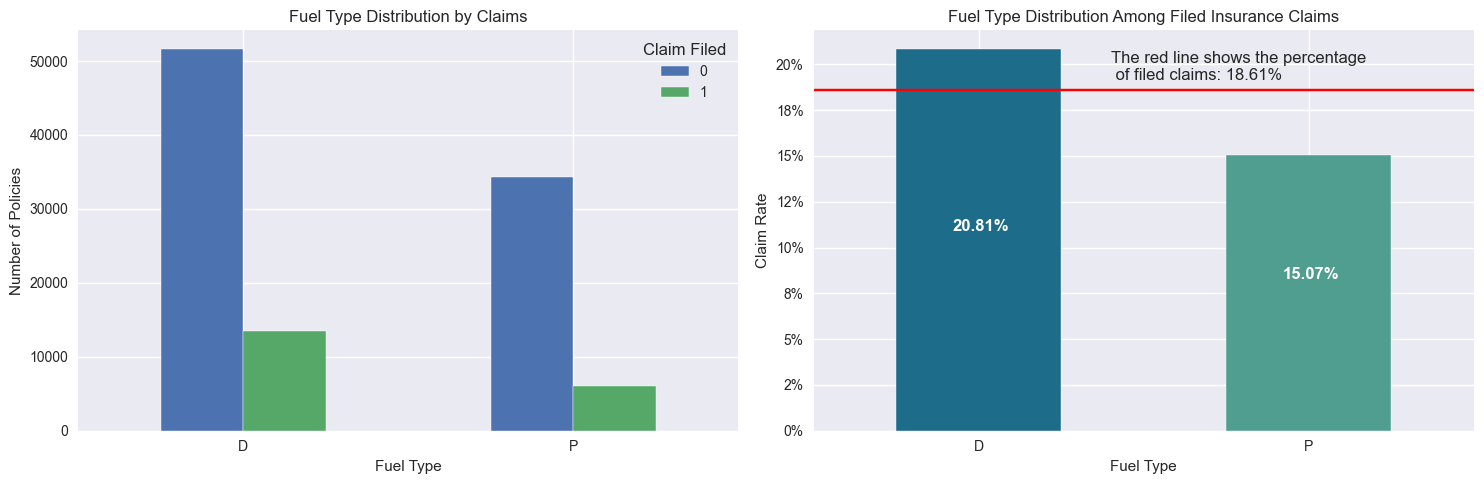

In [45]:
fig, ax = plt.subplots(ncols = 2, figsize=(15, 5))

var_ct = pd.crosstab(index = df['Type_fuel'], columns = df['Claimed'])
var_ct = var_ct.sort_values(by=1, ascending=False)
var_ct.plot(kind = 'bar', ax = ax[0])
ax[0].set(title = 'Fuel Type Distribution by Claims', xlabel = 'Fuel Type', ylabel = 'Number of Policies')
ax[0].legend(title='Claim Filed')
ax[0].xaxis.set_tick_params(labelrotation=0);
    
colors = sns.color_palette('crest', n_colors=len(df['Type_fuel'].unique()))[::-1] # Paleta invertida: mais escuro = maior incidência
df.groupby('Type_fuel')['Claimed'].mean().sort_values(ascending=False).plot(kind = 'bar', color = colors, ax = ax[1])
ax[1].set(title = 'Fuel Type Distribution Among Filed Insurance Claims', xlabel = 'Fuel Type', ylabel = 'Claim Rate')
ax[1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[1].get_yticks()])
ax[1].xaxis.set_tick_params(labelrotation=0)
ax[1].axhline(color='red', y = df['Claimed'].mean());
ax[1].text(transform=ax[1].transAxes, 
                     s = 'The red line shows the percentage\n of filed claims: {}%'.format(round(df['Claimed'].mean()*100, 2)), x =0.45, y=0.875)
ax[1].text(transform=ax[1].transAxes, s = '{}%'.format(round(df.groupby('Type_fuel')['Claimed'].mean()[0]*100, 2)), x =0.21, y=0.5, 
           color = 'white', fontweight='bold')
ax[1].text(transform=ax[1].transAxes, s = '{}%'.format(round(df.groupby('Type_fuel')['Claimed'].mean()[1]*100, 2)), x =0.71, y=0.38, 
           color = 'white', fontweight='bold')
    
plt.tight_layout()
#fig.savefig('graph_bar_fuel_type.png')

In [46]:
# Aufbereitung der Variable 'Type_fuel' zur Verwendung im logistischen Regressionsmodell
df = df.replace(to_replace={'Type_fuel': {'P':0, 'D':1}})
df['Type_fuel'] = df['Type_fuel'].astype('int64')
df['Type_fuel'].dtype

C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\4156183554.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(to_replace={'Type_fuel': {'P':0, 'D':1}})
C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\4156183554.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df = df.replace(to_replace={'Type_fuel': {'P':0, 'D':1}})


dtype('int64')

In [47]:
import statsmodels.api as sm

X = df[['R_Claims_history', 'N_claims_history', 'Policies_in_force', 'Second_driver', 'Type_fuel', 'Seniority', 'Time_drv_license', 'Age']]
y = df['Claimed']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())
coefs = model.params
print(coefs)

Optimization terminated successfully.
         Current function value: 0.320463
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Claimed   No. Observations:               105555
Model:                          Logit   Df Residuals:                   105546
Method:                           MLE   Df Model:                            8
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.3331
Time:                        11:32:50   Log-Likelihood:                -33827.
converged:                       True   LL-Null:                       -50724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.9364      0.053    -54.936      0.000      -3.041      -2.832
R_Claims

In [48]:
#df['weighted_factor'] = (
#        coefs['const']
#        + coefs['R_Claims_history'] * df['R_Claims_history']
#        + coefs['N_claims_history'] * df['N_claims_history']
#        + coefs['Policies_in_force'] * df['Policies_in_force']
#        + coefs['Type_fuel'] * df['Type_fuel']
#        + coefs['Seniority'] * df['Seniority']
#        + coefs['Time_drv_license'] * df['Time_drv_license']
#        + coefs['Age'] * df['Age']
#    )
df['weighted_factor'] = np.dot(X, coefs)
print(df['weighted_factor'].sort_values(ascending=False).head(10))
df['wg_factor_norm'] = (
    (df['weighted_factor'] - df['weighted_factor'].min())
    / (df['weighted_factor'].max() - df['weighted_factor'].min())
    )
print(df['wg_factor_norm'].sort_values(ascending=False).head(10))


60173    8.777572
72598    8.752057
73827    8.748756
59943    8.629643
60174    8.599361
49981    8.574341
57072    8.570967
60873    8.541757
6887     8.515717
29363    8.494853
Name: weighted_factor, dtype: float64
60173    1.000000
72598    0.997946
73827    0.997680
59943    0.988090
60174    0.985652
49981    0.983637
57072    0.983365
60873    0.981014
6887     0.978917
29363    0.977237
Name: wg_factor_norm, dtype: float64


ID
36353    0.997946
36944    0.997680
29875    0.992826
29765    0.988090
24623    0.983637
Name: wg_factor_norm, dtype: float64

np.float64(0.0)

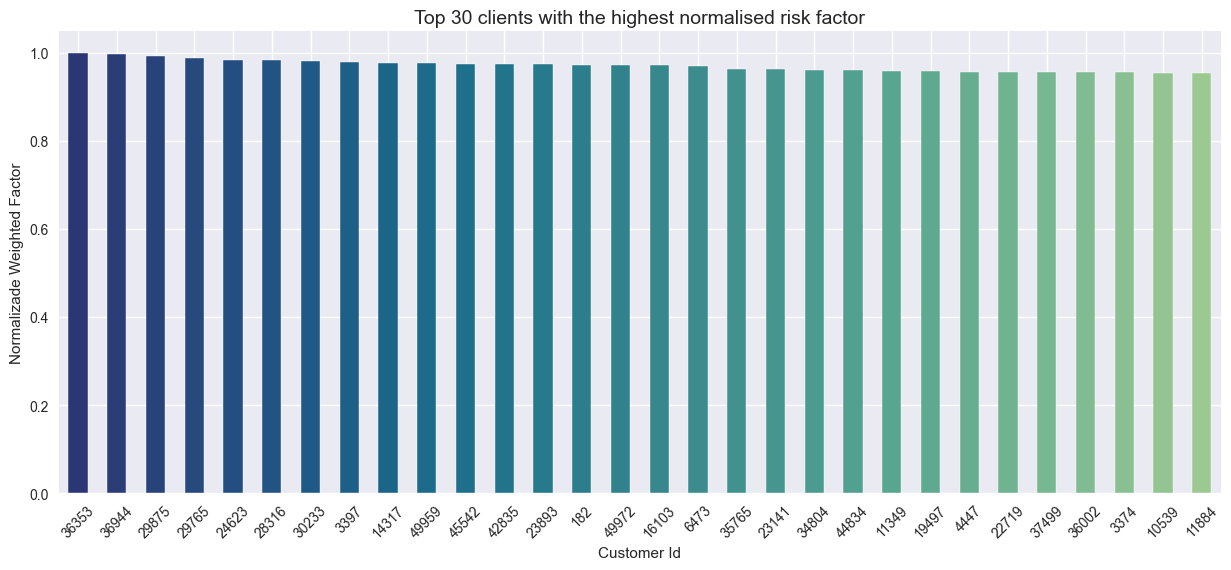

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df_unique = df.groupby('ID')['wg_factor_norm'].mean().sort_values(ascending=False).head(30)
colors = sns.color_palette('crest', n_colors=len(df_unique))[::-1] 
df_unique.plot(kind = 'bar', color = colors, ax=ax)
ax.set_title('Top 30 clients with the highest normalised risk factor', fontsize=14)
ax.set_xlabel('Customer Id')
ax.set_ylabel('Normalizade Weighted Factor')
ax.xaxis.set_tick_params(labelrotation=45);
display(df_unique.head())
display(df['wg_factor_norm'].min())
#fig.savefig('logreg_top30_normriskfactor.png')

Optimization terminated successfully.
         Current function value: 0.320463
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Q("Claimed")   No. Observations:               105555
Model:                          Logit   Df Residuals:                   105553
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.3331
Time:                        11:38:11   Log-Likelihood:                -33827.
converged:                       True   LL-Null:                       -50724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.6427      0.019   -188.138      0.000      -3.681      -3.605
Q(

C:\Users\CLopes\AppData\Local\Temp\ipykernel_10716\3432373062.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


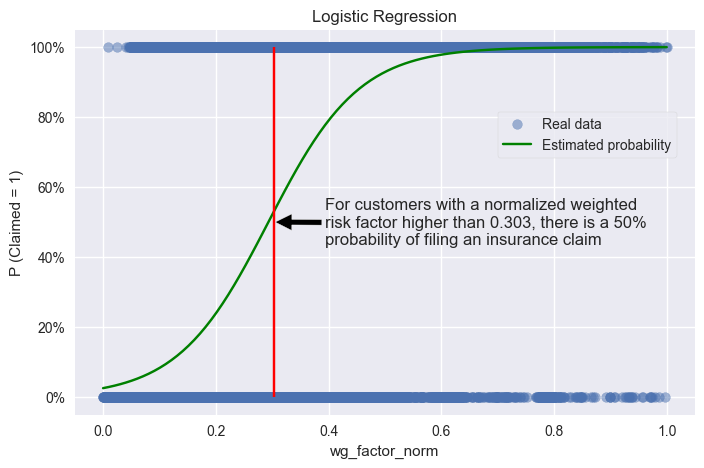

In [58]:
def logistic_reg(predict_val, indep_var, dataframe):
    """
    Logistic regression with probability curve plot.

    Args:
        predict_val (str): name of the column with the variable to be predicted
        indep_var (str): name of the column with the independent variable
        dataframe (DataFrame): DataFrame with the data
        
    Returns:
        prob_X: predicted probabilities for X
    """
    df = dataframe.copy()
    df = df[[predict_val, indep_var]].dropna().reset_index()
    formula = 'Q("{}") ~ Q("{}")'.format(predict_val, indep_var)
    model = smf.logit(formula = formula, data = df) 
    results = model.fit() 
    print(results.summary())
    
    X = np.linspace(df[indep_var].min(), df[indep_var].max(), 100)
    intercept = results.params['Intercept']
    slope = results.params['Q("{}")'.format(indep_var)]
    prob_X = 1 / (1 + math.e ** -(intercept + slope * X))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(dataframe[indep_var], dataframe[predict_val], alpha=0.5, label="Real data")
    ax.plot(X, prob_X, color='green', label="Estimated probability")
    ax.set_title("Logistic Regression")
    ax.set(xlabel = indep_var, ylabel = ('P ({} = 1)'.format(predict_val)))
    x_pos = dataframe[indep_var].max()*0.7
    y_pos = 0.75
    ax.legend(loc='center left', bbox_to_anchor=(x_pos, y_pos), frameon=True, borderaxespad=0, bbox_transform=ax.transData)
    ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
    prob_thr = 0.5
    idx = np.argmax(prob_X >= prob_thr)  
    x_value = X[idx]
    ax.vlines(x=x_value, ymin=0, ymax=1, colors='red', label='Threshold 0.5')
    ann_ax = ax.annotate(xycoords = 'axes fraction',
                         text = 'For customers with a normalized weighted\nrisk factor higher than {:.3f}, there is a {:.0f}%\nprobability of filing an insurance claim'.
                         format(x_value, prob_thr*100), xytext = [x_value+0.1, 0.442], xy = [x_value+0.02, 0.5], arrowprops=dict(facecolor='black'), fontsize = 12)
    print(x_value)
    fig.savefig('logreg_prob50_claim.png')

logistic_reg('Claimed', 'wg_factor_norm', df)


In [57]:
df[df['wg_factor_norm'] > 0.303].count()

ID                      11073
Date_start_contract     11073
Date_last_renewal       11073
Date_next_renewal       11073
Date_birth              11073
Age                     11073
Date_driving_licence    11073
Time_drv_license        11073
Distribution_channel    11073
Seniority               11073
Policies_in_force       11073
Max_policies            11073
Max_products            11073
Lapse                   11073
Date_lapse               5664
Payment                 11073
Premium                 11073
Cost_claims_year        11073
N_claims_year           11073
N_claims_history        11073
R_Claims_history        11073
Type_risk               11073
Area                    11073
Second_driver           11073
Year_matriculation      11073
Power                   11073
Cylinder_capacity       11073
Value_vehicle           11073
N_doors                 11073
Type_fuel               11073
Length                  10601
Weight                  11073
Claimed                 11073
weighted_f

In [52]:
df['ID'].nunique()

53502

In [53]:
df[df['wg_factor_norm'] > 0.303].nunique()

ID                       6828
Date_start_contract      1896
Date_last_renewal        1113
Date_next_renewal        1113
Date_birth               5312
Age                        61
Date_driving_licence     4819
Time_drv_license           60
Distribution_channel        2
Seniority                  38
Policies_in_force          17
Max_policies               16
Max_products                4
Lapse                       7
Date_lapse               1090
Payment                     2
Premium                  9393
Cost_claims_year         6020
N_claims_year              22
N_claims_history           46
R_Claims_history          381
Type_risk                   3
Area                        2
Second_driver               2
Year_matriculation         45
Power                     170
Cylinder_capacity         312
Value_vehicle            3406
N_doors                     6
Type_fuel                   2
Length                    741
Weight                    955
Claimed                     2
weighted_f